# The file is an analysis of the preliminary $\alpha_{\textrm{CE}}$ variation run following the methods in the tutorial from the compas repo.

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
from matplotlib import rc
import astropy.units as u
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data_Analysis/Scripts/')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects
from formation_channels import identify_formation_channels

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_23957/2399680313.py:33: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


# 1. Create Compas data objects
##  a) Condense the each of the batch's outputs into one h5 file
Function that combines all of the h5 files from each batch. It will write and return the complete h5 file

In [2]:
def condense_h5s(output_dir):

    index = 0 # A useful variable for indexing through the files in the output directory

    # Iterate through the files in the output directory
    for dir in os.listdir(output_dir):
        
        # Make sure that the directories are from the batches
        if dir[0:5] == 'batch':
            batch_num = dir [-1]
            f_h5 = h5.File(output_dir + '/batch_' + batch_num + '/batch_' + batch_num + '.h5', 'r')
            
            # If it's the first batch directory, create an h5 file and copy the first batch's contents into it
            if index == 0:
                # Create an h5 file to put all of the batch's h5 files in
                complete_h5 = h5.File(output_dir + '/complete.h5', 'w')

                # Create and copy the first batch's h5 file into the complete_h5 file
                # DCOs = complete_h5.create_group('BSE_Double_Compact_Objects')
                for group in f_h5.keys():
                    # complete_h5.create_group(group)
                    f_h5.copy(f_h5[group], complete_h5)
                
                DCOs = complete_h5['BSE_Double_Compact_Objects']
                CEs = complete_h5['BSE_Common_Envelopes']
                RLOFs = complete_h5['BSE_RLOF']
                SNs = complete_h5['BSE_Supernovae']
                SPs = complete_h5['BSE_System_Parameters']
                RDs = complete_h5['Run_Details']
                
            # If it's not the first directory, append the new data to each group in the complete h5 file
            else:
                # Append new data to it
                for key in DCOs.keys():
                    DCOs[key].resize((DCOs[key].shape[0] + f_h5['BSE_Double_Compact_Objects'][key].shape[0]), axis=0)
                    DCOs[key][-f_h5['BSE_Double_Compact_Objects'][key].shape[0]:] = f_h5['BSE_Double_Compact_Objects'][key]
                
                for key in CEs.keys():
                    CEs[key].resize((CEs[key].shape[0] + f_h5['BSE_Common_Envelopes'][key].shape[0]), axis=0)
                    CEs[key][-f_h5['BSE_Common_Envelopes'][key].shape[0]:] = f_h5['BSE_Common_Envelopes'][key]
                
                for key in RLOFs.keys():
                    RLOFs[key].resize((RLOFs[key].shape[0] + f_h5['BSE_RLOF'][key].shape[0]), axis=0)
                    RLOFs[key][-f_h5['BSE_RLOF'][key].shape[0]:] = f_h5['BSE_RLOF'][key]
                
                for key in SNs.keys():
                    SNs[key].resize((SNs[key].shape[0] + f_h5['BSE_Supernovae'][key].shape[0]), axis=0)
                    SNs[key][-f_h5['BSE_Supernovae'][key].shape[0]:] = f_h5['BSE_Supernovae'][key]
                
                for key in SPs.keys():
                    SPs[key].resize((SPs[key].shape[0] + f_h5['BSE_System_Parameters'][key].shape[0]), axis=0)
                    SPs[key][-f_h5['BSE_System_Parameters'][key].shape[0]:] = f_h5['BSE_System_Parameters'][key]
                
                for key in RDs.keys():
                    RDs[key].resize((RDs[key].shape[0] + f_h5['Run_Details'][key].shape[0]), axis=0)
                    RDs[key][-f_h5['Run_Details'][key].shape[0]:] = f_h5['Run_Details'][key]

            index+=1 # Update the index
            f_h5.close() # Close the batch file

    complete_h5.close() # Close the complete h5 file
    return output_dir + '/complete.h5'

Condense all .h5 file outputs for the common envelope alpha values

In [ ]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
condensed_paths = []

for alpha in alpha_vals:
    condensed_paths.append(condense_h5s('/Users/adamboesky/Research/PRISE/exploring_parameter_space/output_common_envelope_alpha/output_' + alpha))

*** To use if the h5 files have already been condensed! ***

In [3]:
# To use if the h5 files have already been condensed!
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
condensed_paths = []

for alpha in alpha_vals:
    condensed_paths.append('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_common_envelope_alpha/output_' + alpha + '/complete.h5')

## b) Create COMPASData objects for each of the $\alpha_{\textrm{CE}}$ values

In [7]:
print(f_h5['BSE_RLOF'].keys())


<KeysViewHDF5 ['CEE>MT', 'Eccentricity<MT', 'Eccentricity>MT', 'MT_Event_Counter', 'Mass(1)<MT', 'Mass(1)>MT', 'Mass(2)<MT', 'Mass(2)>MT', 'RLOF(1)<MT', 'RLOF(1)>MT', 'RLOF(2)<MT', 'RLOF(2)>MT', 'Radius(1)<MT', 'Radius(1)>MT', 'Radius(1)|RL<step', 'Radius(1)|RL>step', 'Radius(2)<MT', 'Radius(2)>MT', 'Radius(2)|RL<step', 'Radius(2)|RL>step', 'SEED', 'SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(1)>MT', 'Stellar_Type(2)<MT', 'Stellar_Type(2)>MT', 'Time<MT', 'Time>MT', 'Zeta_Hurley(1)', 'Zeta_Hurley(2)', 'Zeta_Hurley_He(1)', 'Zeta_Hurley_He(2)', 'Zeta_Soberman(1)', 'Zeta_Soberman(2)', 'Zeta_Soberman_He(1)', 'Zeta_Soberman_He(2)']>


In [13]:
f_h5['BSE_RLOF'].keys()
# print(f_h5['BSE_RLOF']['Radius(1)|RL'][0:10])

<KeysViewHDF5 ['CEE>MT', 'Eccentricity<MT', 'Eccentricity>MT', 'MT_Event_Counter', 'Mass(1)<MT', 'Mass(1)>MT', 'Mass(2)<MT', 'Mass(2)>MT', 'RLOF(1)<MT', 'RLOF(1)>MT', 'RLOF(2)<MT', 'RLOF(2)>MT', 'Radius(1)<MT', 'Radius(1)>MT', 'Radius(1)|RL<step', 'Radius(1)|RL>step', 'Radius(2)<MT', 'Radius(2)>MT', 'Radius(2)|RL<step', 'Radius(2)|RL>step', 'SEED', 'SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(1)>MT', 'Stellar_Type(2)<MT', 'Stellar_Type(2)>MT', 'Time<MT', 'Time>MT', 'Zeta_Hurley(1)', 'Zeta_Hurley(2)', 'Zeta_Hurley_He(1)', 'Zeta_Hurley_He(2)', 'Zeta_Soberman(1)', 'Zeta_Soberman(2)', 'Zeta_Soberman_He(1)', 'Zeta_Soberman_He(2)']>

In [5]:
# For now, assume all the defaults and just set the paths for each value
alpha_data = {}
for index, val in enumerate(alpha_vals):
    alpha_data[val] = ClassCOMPAS.COMPASData(path=condensed_paths[index])

ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


In [ ]:
for key, data in alpha_data.items():
    data.Mlower = 5
    data.Mupper = 150
    data.binaryFraction =0.7

    data.setGridAndMassEvolved()

KeyboardInterrupt: 

## c) Check the number of each type of system in the runs

In [5]:
for key, data in alpha_data.items():
    data.setCOMPASDCOmask(types='BBH', pessimistic=True)
    
    #Check if we have any system meeting the criteria
    print('Number of BBH systems at alpha_CE = {alpha}'.format(alpha=float(key)), np.sum(alpha_data[key].DCOmask))

print('')

for key, data in alpha_data.items():
    data.setCOMPASDCOmask(types='BNS', pessimistic=True)
    
    #Check if we have any system meeting the criteria
    print('Number of BNS systems at alpha_CE = {alpha}'.format(alpha=float(key)), np.sum(alpha_data[key].DCOmask))

print('')
for key, data in alpha_data.items():
    data.setCOMPASDCOmask(types='BHNS', pessimistic=True)
    
    #Check if we have any system meeting the criteria
    print('Number of BHNS systems at alpha_CE = {alpha}'.format(alpha=float(key)), np.sum(alpha_data[key].DCOmask))

Number of BBH systems at alpha_CE = 0.1 94337
Number of BBH systems at alpha_CE = 0.5 174370
Number of BBH systems at alpha_CE = 2.0 192419
Number of BBH systems at alpha_CE = 10.0 124406

Number of BNS systems at alpha_CE = 0.1 302
Number of BNS systems at alpha_CE = 0.5 109
Number of BNS systems at alpha_CE = 2.0 770
Number of BNS systems at alpha_CE = 10.0 1311

Number of BHNS systems at alpha_CE = 0.1 388
Number of BHNS systems at alpha_CE = 0.5 985
Number of BHNS systems at alpha_CE = 2.0 7705
Number of BHNS systems at alpha_CE = 10.0 7746


In [ ]:
for key, data in alpha_data.items():
    data.setCOMPASData()

## d) Check the number of systems formed by each channel

In [ ]:
f_h5 = h5.File(condensed_paths[2])
dcos = f_h5['BSE_Double_Compact_Objects']
seeds = dcos['SEED']
channels = identify_formation_channels(seeds, f_h5)
print(sum(channels))

channel_counts = {}
channel_counts['0'] = np.count_nonzero(channels == 0)
channel_counts['1'] = np.count_nonzero(channels == 1)
channel_counts['2'] = np.count_nonzero(channels == 2)
channel_counts['3'] = np.count_nonzero(channels == 3)
channel_counts['4'] = np.count_nonzero(channels == 4)
channel_counts['5'] = np.count_nonzero(channels == 5)


print(channel_counts)

347326
{'0': 99004, '1': 87443, '2': 65693, '3': 987, '4': 31384, '5': 0}


# 2. Take a look at the different MSSFR models

In [7]:
#We use the defaults and for illustration purposes invent our own grid

#Absolute metallicities
metallicityGrid = np.logspace(-4, -1.5,100)

MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


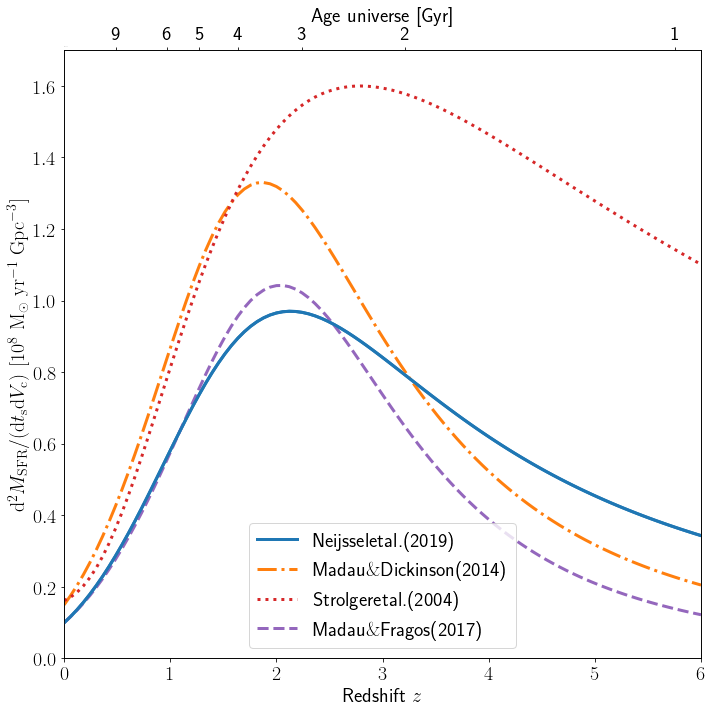

In [8]:
# fontsize
fs = 20

clist=['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Plotting the SFR prescriptions
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = MSSFR.cosmology.age(redshifts).value

models = [ MSSFR.SFR_Neijssel(redshifts), MSSFR.SFR_Madau(redshifts),   
           MSSFR.SFR_Strolger(ages), MSSFR.SFR_Madau2(redshifts) ]
labels = [ r'Neijsseletal.(2019)', r'Madau$\&$Dickinson(2014)',
           r'Strolgeretal.(2004)', r'Madau$\&$Fragos(2017)']
ls     = [ '-', '-.', ':', '--']

fig, axes = plt.subplots(1,1, figsize=(10,10))
for ii, model in enumerate(models):
    axes.plot(redshifts, model,  c=clist[ii], lw=3., label=labels[ii], linestyle=ls[ii])
    #            axes.plot(redshifts,  c=clist[1], lw=3., label=      , linestyle=
    #                  axes.plot(redshifts,  c=clist[2], lw=3., label=, linestyle=
    #               axes.plot(redshifts,  c=clist[3], lw=3., label=   , linestyle=


axes2  = axes.twiny()
axes2.plot(redshifts, MSSFR.SFR_Neijssel(redshifts), c=clist[0], lw=3., label='Preferred model')


#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,6, 9]) #Gyr
ageUniverse = MSSFR.cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

axes2.set_xticks(redshiftTicks)
axes2.set_xticklabels(agelabels)

# axes layout
nameX = r'Redshift $z$'
nameY = r'$ {\rm{d}}^2M_{\rm{SFR}}/({\rm{d}}t_{{\rm{s}}}{\rm{d}}V_{\rm{c}}) \   [10^8\ {\rm{M}}_{\odot}\  {\rm{yr}}^{-1}\ {\rm{Gpc}}^{-3}]$'
axes.legend(loc=8, prop={'size':fs})
axes.yaxis.offsetText.set_fontsize(0.1)
axes.set_ylim(0, 1.7*10**8)
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)
axes.set_xlim(0,6)

# second x-axis for age
axes2.set_xlabel('Age universe [Gyr]', fontsize=fs)
axes2.tick_params(labelsize=fs)
axes2.set_xlim(0,6)

plt.tight_layout()

# 3. Get the detection rates

Import a function that will quickly calculate and return the probability density function (PDF) for a given distribution

In [ ]:
from KDEpy import FFTKDE  # Fastest 1D algorithm

## a) NSNS

In [3]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 5 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

In [ ]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for index, val in enumerate(alpha_vals):
    bns_detection_rates[val], bns_formation_rates[val], bns_merger_rates[val], bns_redshifts[val], bns_COMPASs[val] = FCI.find_detection_rate(
    condensed_paths[index], dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_4508/3486541201.py:8: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  detection_rates[val], formation_rates[val], merger_rates[val], redshifts[val], COMPASs[val] = FCI.find_detection_rate(


Average_SF_mass_needed =  235398855.48199868 solMass
Average_SF_mass_needed =  236197913.07033184 solMass
Average_SF_mass_needed =  234398688.32646078 solMass
Average_SF_mass_needed =  235265306.4119708 solMass


In [ ]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for index, val in enumerate(alpha_vals):
    bns_chirp_masses[val] = (bns_COMPASs[val].mass1*bns_COMPASs[val].mass2)**(3./5.) / (bns_COMPASs[val].mass1 + bns_COMPASs[val].mass2)**(1./5.)

    # sum things up across binaries
    bns_total_formation_rates[val] = np.sum(bns_formation_rates[val], axis=0)
    bns_total_merger_rates[val] = np.sum(bns_merger_rates[val], axis=0)
    bns_total_detection_rates[val] = np.sum(bns_detection_rates[val], axis=0)

    # and across redshifts
    bns_cumulative_detection_rates[val] = np.cumsum(bns_total_detection_rates[val])
    bns_detection_rates_by_binary[val] = np.sum(bns_detection_rates[val], axis=1)

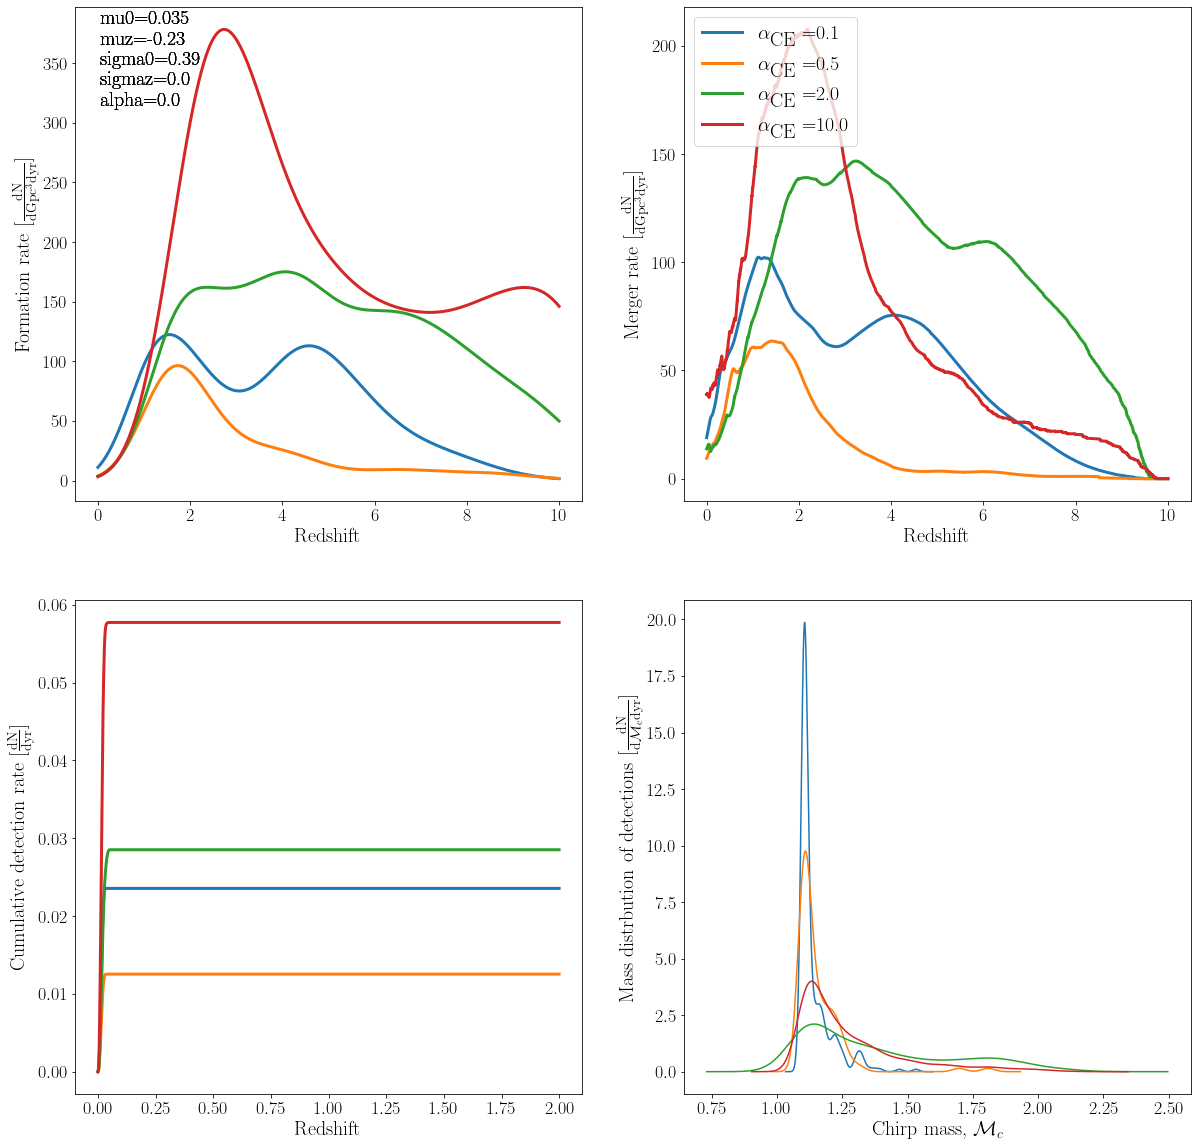

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for val in alpha_vals:

        axes[0,0].plot(bns_redshifts[val], bns_total_formation_rates[val], lw=lw)
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].plot(bns_redshifts[val], bns_total_merger_rates[val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + val)
        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
        axes[0,1].legend(loc='upper left', prop={'size': 20})

        axes[1,0].plot(bns_redshifts[val][:len(bns_cumulative_detection_rates[val])], bns_cumulative_detection_rates[val], lw=lw)
        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[val]).evaluate()
        # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
        axes[1,1].plot(bns_axis, bns_mass_kde)        
        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        #########################
        # Plotvalues

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 

        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)
        # Save and show :)
        # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## b) BHNS

In [ ]:
dco_type        = "BHNS"

In [ ]:
bhns_detection_rates = {}
bhns_formation_rates = {}
bhns_merger_rates = {}
bhns_redshifts = {}
bhns_COMPASs = {}

for index, val in enumerate(alpha_vals):
    bhns_detection_rates[val], bhns_formation_rates[val], bhns_merger_rates[val], bhns_redshifts[val], bhns_COMPASs[val] = FCI.find_detection_rate(
    condensed_paths[index], dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_4508/3486541201.py:8: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  detection_rates[val], formation_rates[val], merger_rates[val], redshifts[val], COMPASs[val] = FCI.find_detection_rate(


Average_SF_mass_needed =  235731190.48515067 solMass
Average_SF_mass_needed =  234736793.59022436 solMass
Average_SF_mass_needed =  234508977.56611702 solMass
Average_SF_mass_needed =  235105900.106127 solMass


In [ ]:
bhns_total_formation_rates = {}
bhns_total_merger_rates = {}
bhns_total_detection_rates = {}
bhns_cumulative_detection_rates = {}
bhns_detection_rates_by_binary = {}
bhns_chirp_masses = {}

for index, val in enumerate(alpha_vals):
    bhns_chirp_masses[val] = (bhns_COMPASs[val].mass1*bhns_COMPASs[val].mass2)**(3./5.) / (bhns_COMPASs[val].mass1 + bhns_COMPASs[val].mass2)**(1./5.)

    # sum things up across binaries
    bhns_total_formation_rates[val] = np.sum(bhns_formation_rates[val], axis=0)
    bhns_total_merger_rates[val] = np.sum(bhns_merger_rates[val], axis=0)
    bhns_total_detection_rates[val] = np.sum(bhns_detection_rates[val], axis=0)

    # and across redshifts
    bhns_cumulative_detection_rates[val] = np.cumsum(bhns_total_detection_rates[val])
    bhns_detection_rates_by_binary[val] = np.sum(bhns_detection_rates[val], axis=1)

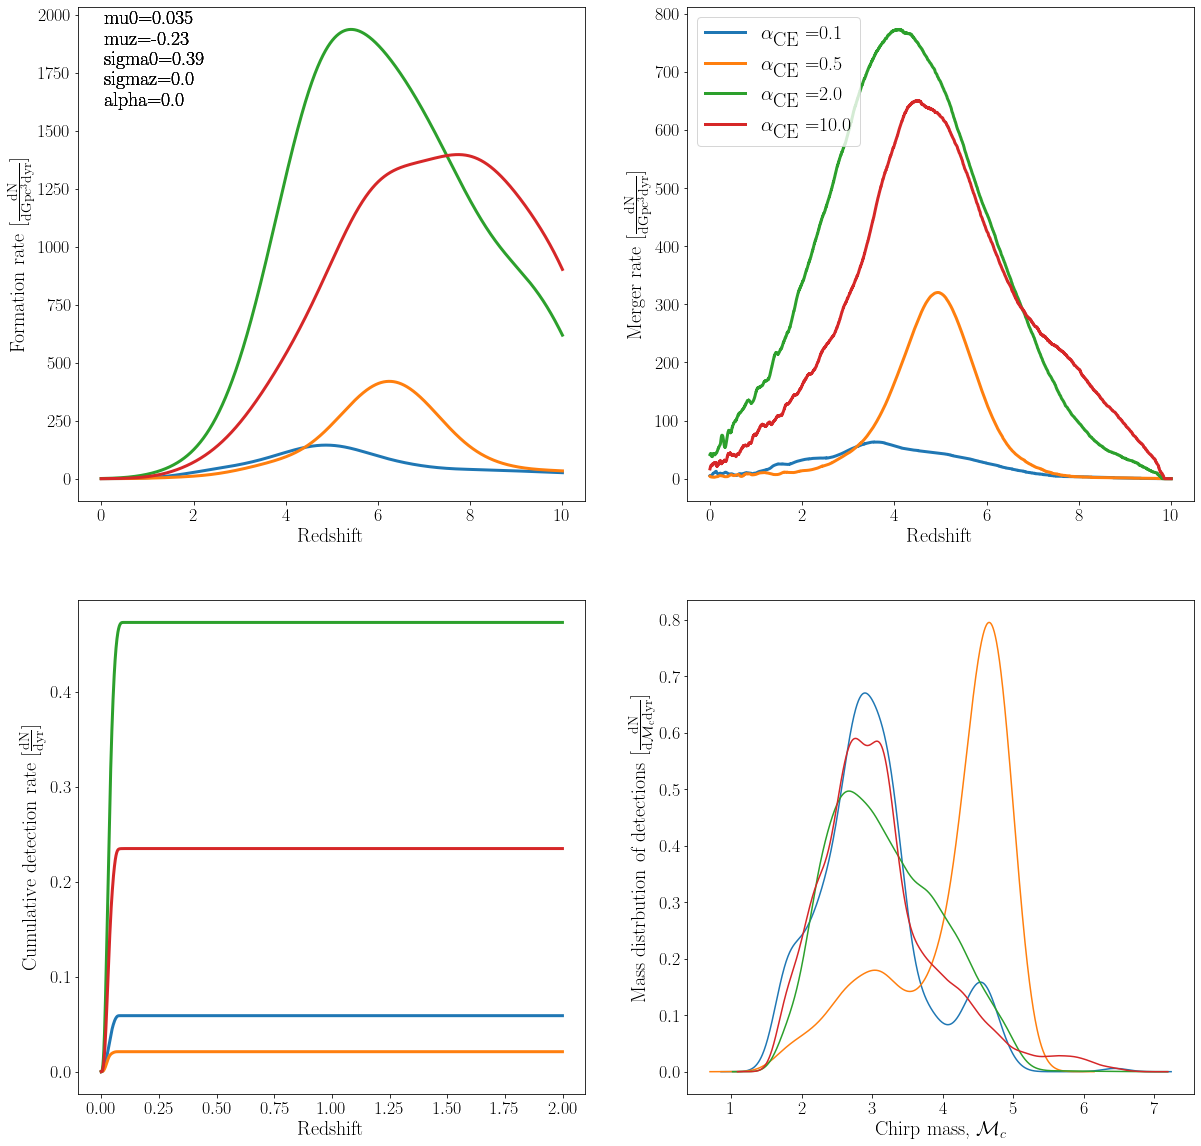

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for val in alpha_vals:

        axes[0,0].plot(bhns_redshifts[val], bhns_total_formation_rates[val], lw=lw)
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].plot(bhns_redshifts[val], bhns_total_merger_rates[val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + val)
        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
        axes[0,1].legend(loc='upper left', prop={'size': 20})

        axes[1,0].plot(bhns_redshifts[val][:len(bhns_cumulative_detection_rates[val])], bhns_cumulative_detection_rates[val], lw=lw)
        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        bhns_axis, bhns_mass_kde = FFTKDE(bw='silverman').fit(bhns_chirp_masses[val]).evaluate()
        # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
        axes[1,1].plot(bhns_axis, bhns_mass_kd, lw=lw)
        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        #########################
        # Plotvalues

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 

        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)
        # Save and show :)
        # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## c) BHBH

In [4]:
dco_type        = "BBH"

In [26]:
bbh_detection_rates = {}
bbh_formation_rates = {}
bbh_merger_rates = {}
bbh_redshifts = {}
bbh_COMPASs = {}

for path in condensed_paths:
    COMPASData = ClassCOMPAS.COMPASData(path=path)
    COMPASData.setCOMPASData()
    # COMPASData.Mlower = 15
    # COMPASData.Mupper = 150
    # COMPASData.binaryFraction =0.7

    # COMPASData.setGridAndMassEvolved()
    
    # print(COMPASData.initialZ)
    # print(np.log(np.max(COMPASData.initialZ)))
    # print(np.log(np.min(COMPASData.initialZ)) == np.log(np.max(COMPASData.initialZ)))
    # print(np.log(np.min(COMPASData.initialZ)))
    # print(np.log(np.max(COMPASData.initialZ)))
    # print(np.log(np.min(COMPASData.initialZ)) == np.log(np.max(COMPASData.initialZ)))
    # assert True, "You cannot perform cosmic integration with just one metallicity" 


ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
False
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
False
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
False
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
False


In [5]:
bbh_detection_rates = {}
bbh_formation_rates = {}
bbh_merger_rates = {}
bbh_redshifts = {}
bbh_COMPASs = {}

for index, val in enumerate(alpha_vals):
    bbh_detection_rates[val], bbh_formation_rates[val], bbh_merger_rates[val], bbh_redshifts[val], bbh_COMPASs[val] = FCI.find_detection_rate(
    condensed_paths[index], dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_7532/666689185.py:8: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  bbh_detection_rates[val], bbh_formation_rates[val], bbh_merger_rates[val], bbh_redshifts[val], bbh_COMPASs[val] = FCI.find_detection_rate(


Average_SF_mass_needed =  235157356.75627187 solMass
Average_SF_mass_needed =  236370523.57808933 solMass
Average_SF_mass_needed =  235289461.76441866 solMass
Average_SF_mass_needed =  235780231.40750718 solMass


: 

: 

In [ ]:
bbh_total_formation_rates = {}
bbh_total_merger_rates = {}
bbh_total_detection_rates = {}
bbh_cumulative_detection_rates = {}
bbh_detection_rates_by_binary = {}
bbh_chirp_masses = {}

for index, val in enumerate(alpha_vals):
    bbh_chirp_masses[val] = (bbh_COMPASs[val].mass1*bbh_COMPASs[val].mass2)**(3./5.) / (bbh_COMPASs[val].mass1 + bbh_COMPASs[val].mass2)**(1./5.)

    # sum things up across binaries
    bbh_total_formation_rates[val] = np.sum(bbh_formation_rates[val], axis=0)
    bbh_total_merger_rates[val] = np.sum(bbh_merger_rates[val], axis=0)
    bbh_total_detection_rates[val] = np.sum(bbh_detection_rates[val], axis=0)

    # and across redshifts
    bbh_cumulative_detection_rates[val] = np.cumsum(bbh_total_detection_rates[val])
    bbh_detection_rates_by_binary[val] = np.sum(bbh_detection_rates[val], axis=1)

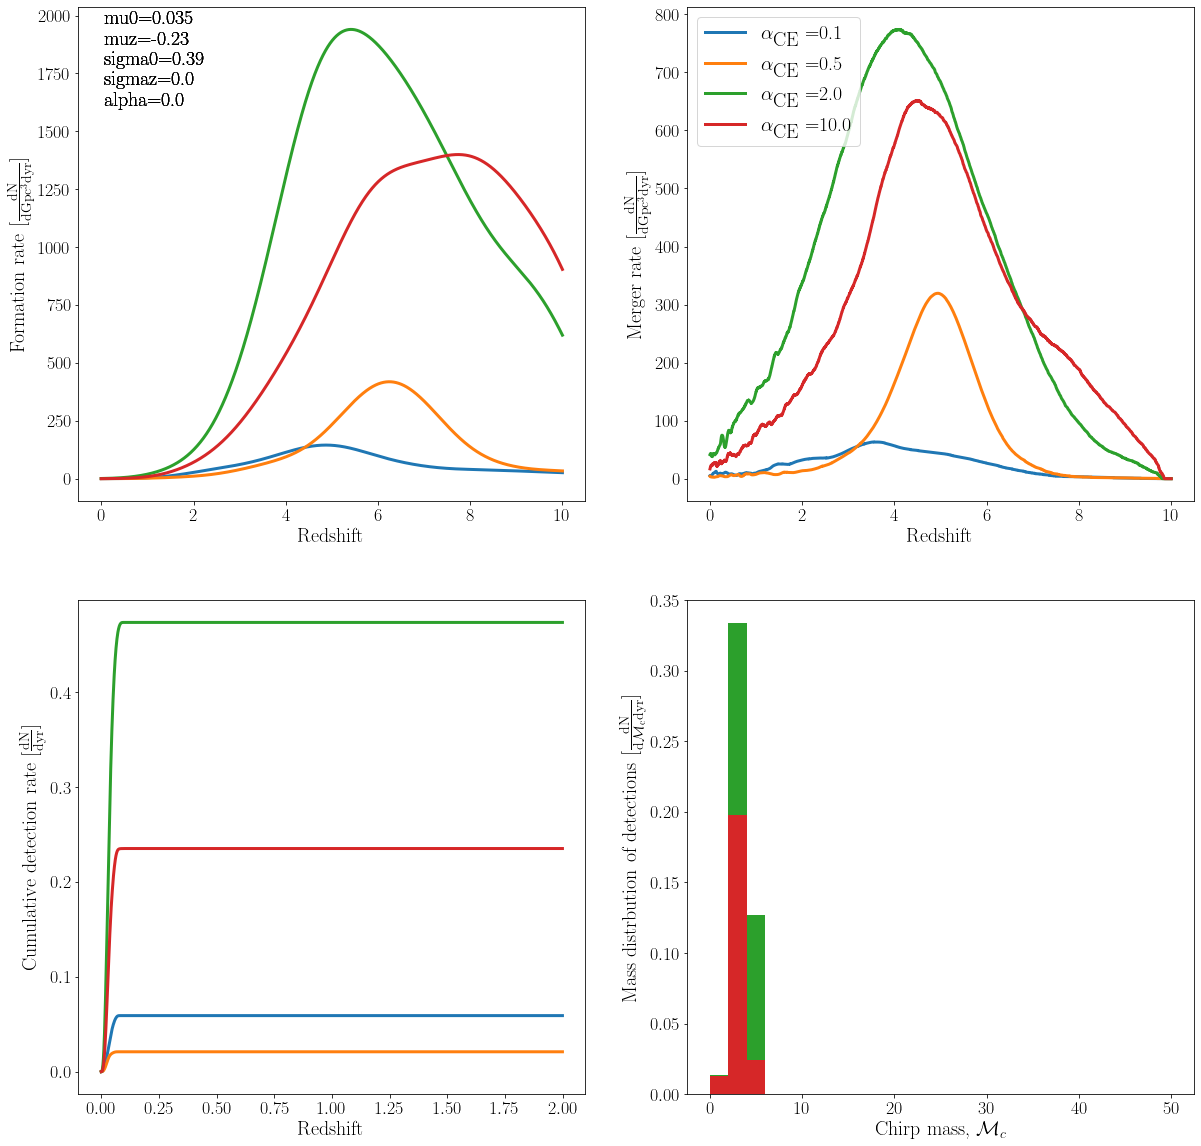

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for val in alpha_vals:

        axes[0,0].plot(bbh_redshifts[val], bbh_total_formation_rates[val], lw=lw)
        axes[0,0].set_xlabel('Redshift', fontsize=fs)
        axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

        axes[0,1].plot(bbh_redshifts[val], bbh_total_merger_rates[val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + val)
        axes[0,1].set_xlabel('Redshift', fontsize=fs)
        axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
        axes[0,1].legend(loc='upper left', prop={'size': 20})

        axes[1,0].plot(bbh_redshifts[val][:len(bbh_cumulative_detection_rates[val])], bbh_cumulative_detection_rates[val], lw=lw)
        axes[1,0].set_xlabel('Redshift', fontsize=fs)
        axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

        bbh_axis, bbh_mass_kde = FFTKDE(bw='silverman').fit(bbh_chirp_masses[val]).evaluate()
        # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
        axes[1,1].plot(bbh_axis, bbh_mass_kde)
        axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
        axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

        #########################
        # Plotvalues

        # Add text upper left corner
        axes[0,0].text(0.05,0.8, 
                "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                transform=axes[0,0].transAxes, size = fs) 

        for ax in axes.flatten():
                ax.tick_params(labelsize=0.9*fs)
        # Save and show :)
        # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 